<a href="https://colab.research.google.com/github/yasinsoylu1997/224-224-undersampling/blob/main/vgg19_models_224_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras
!pip install catboost

In [3]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [4]:
X = []
y = []
image_size = 224
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:05<00:00, 252.20it/s]


In [5]:
from imblearn.under_sampling import RandomUnderSampler 

reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomUnderSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,224,224,3)
oversampled_y

array(['COVID', 'COVID', 'COVID', ..., 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia'], dtype='<U15')

In [6]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

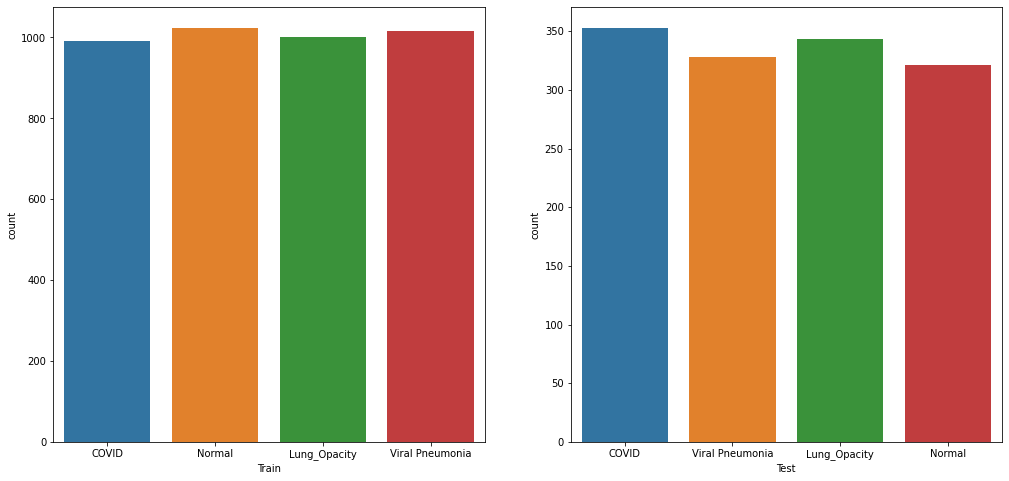

In [7]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [10]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [12]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_model= features #This is our X input for model

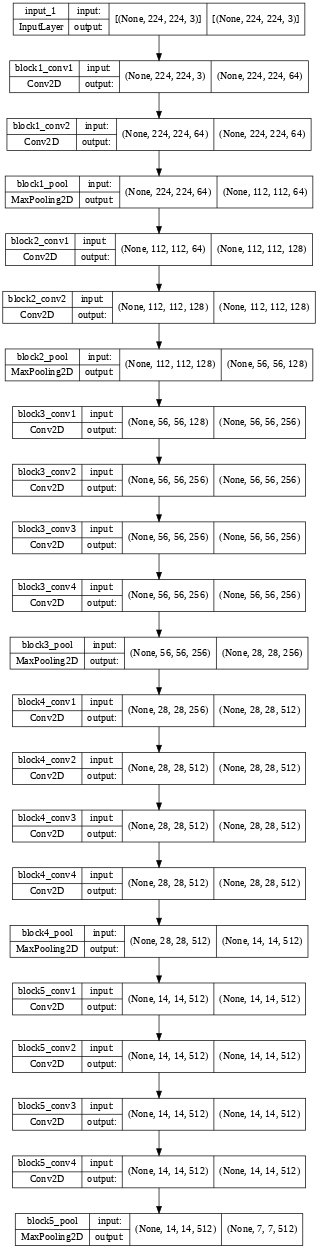

In [14]:
from keras.utils.vis_utils import plot_model

plot_model(VGG_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

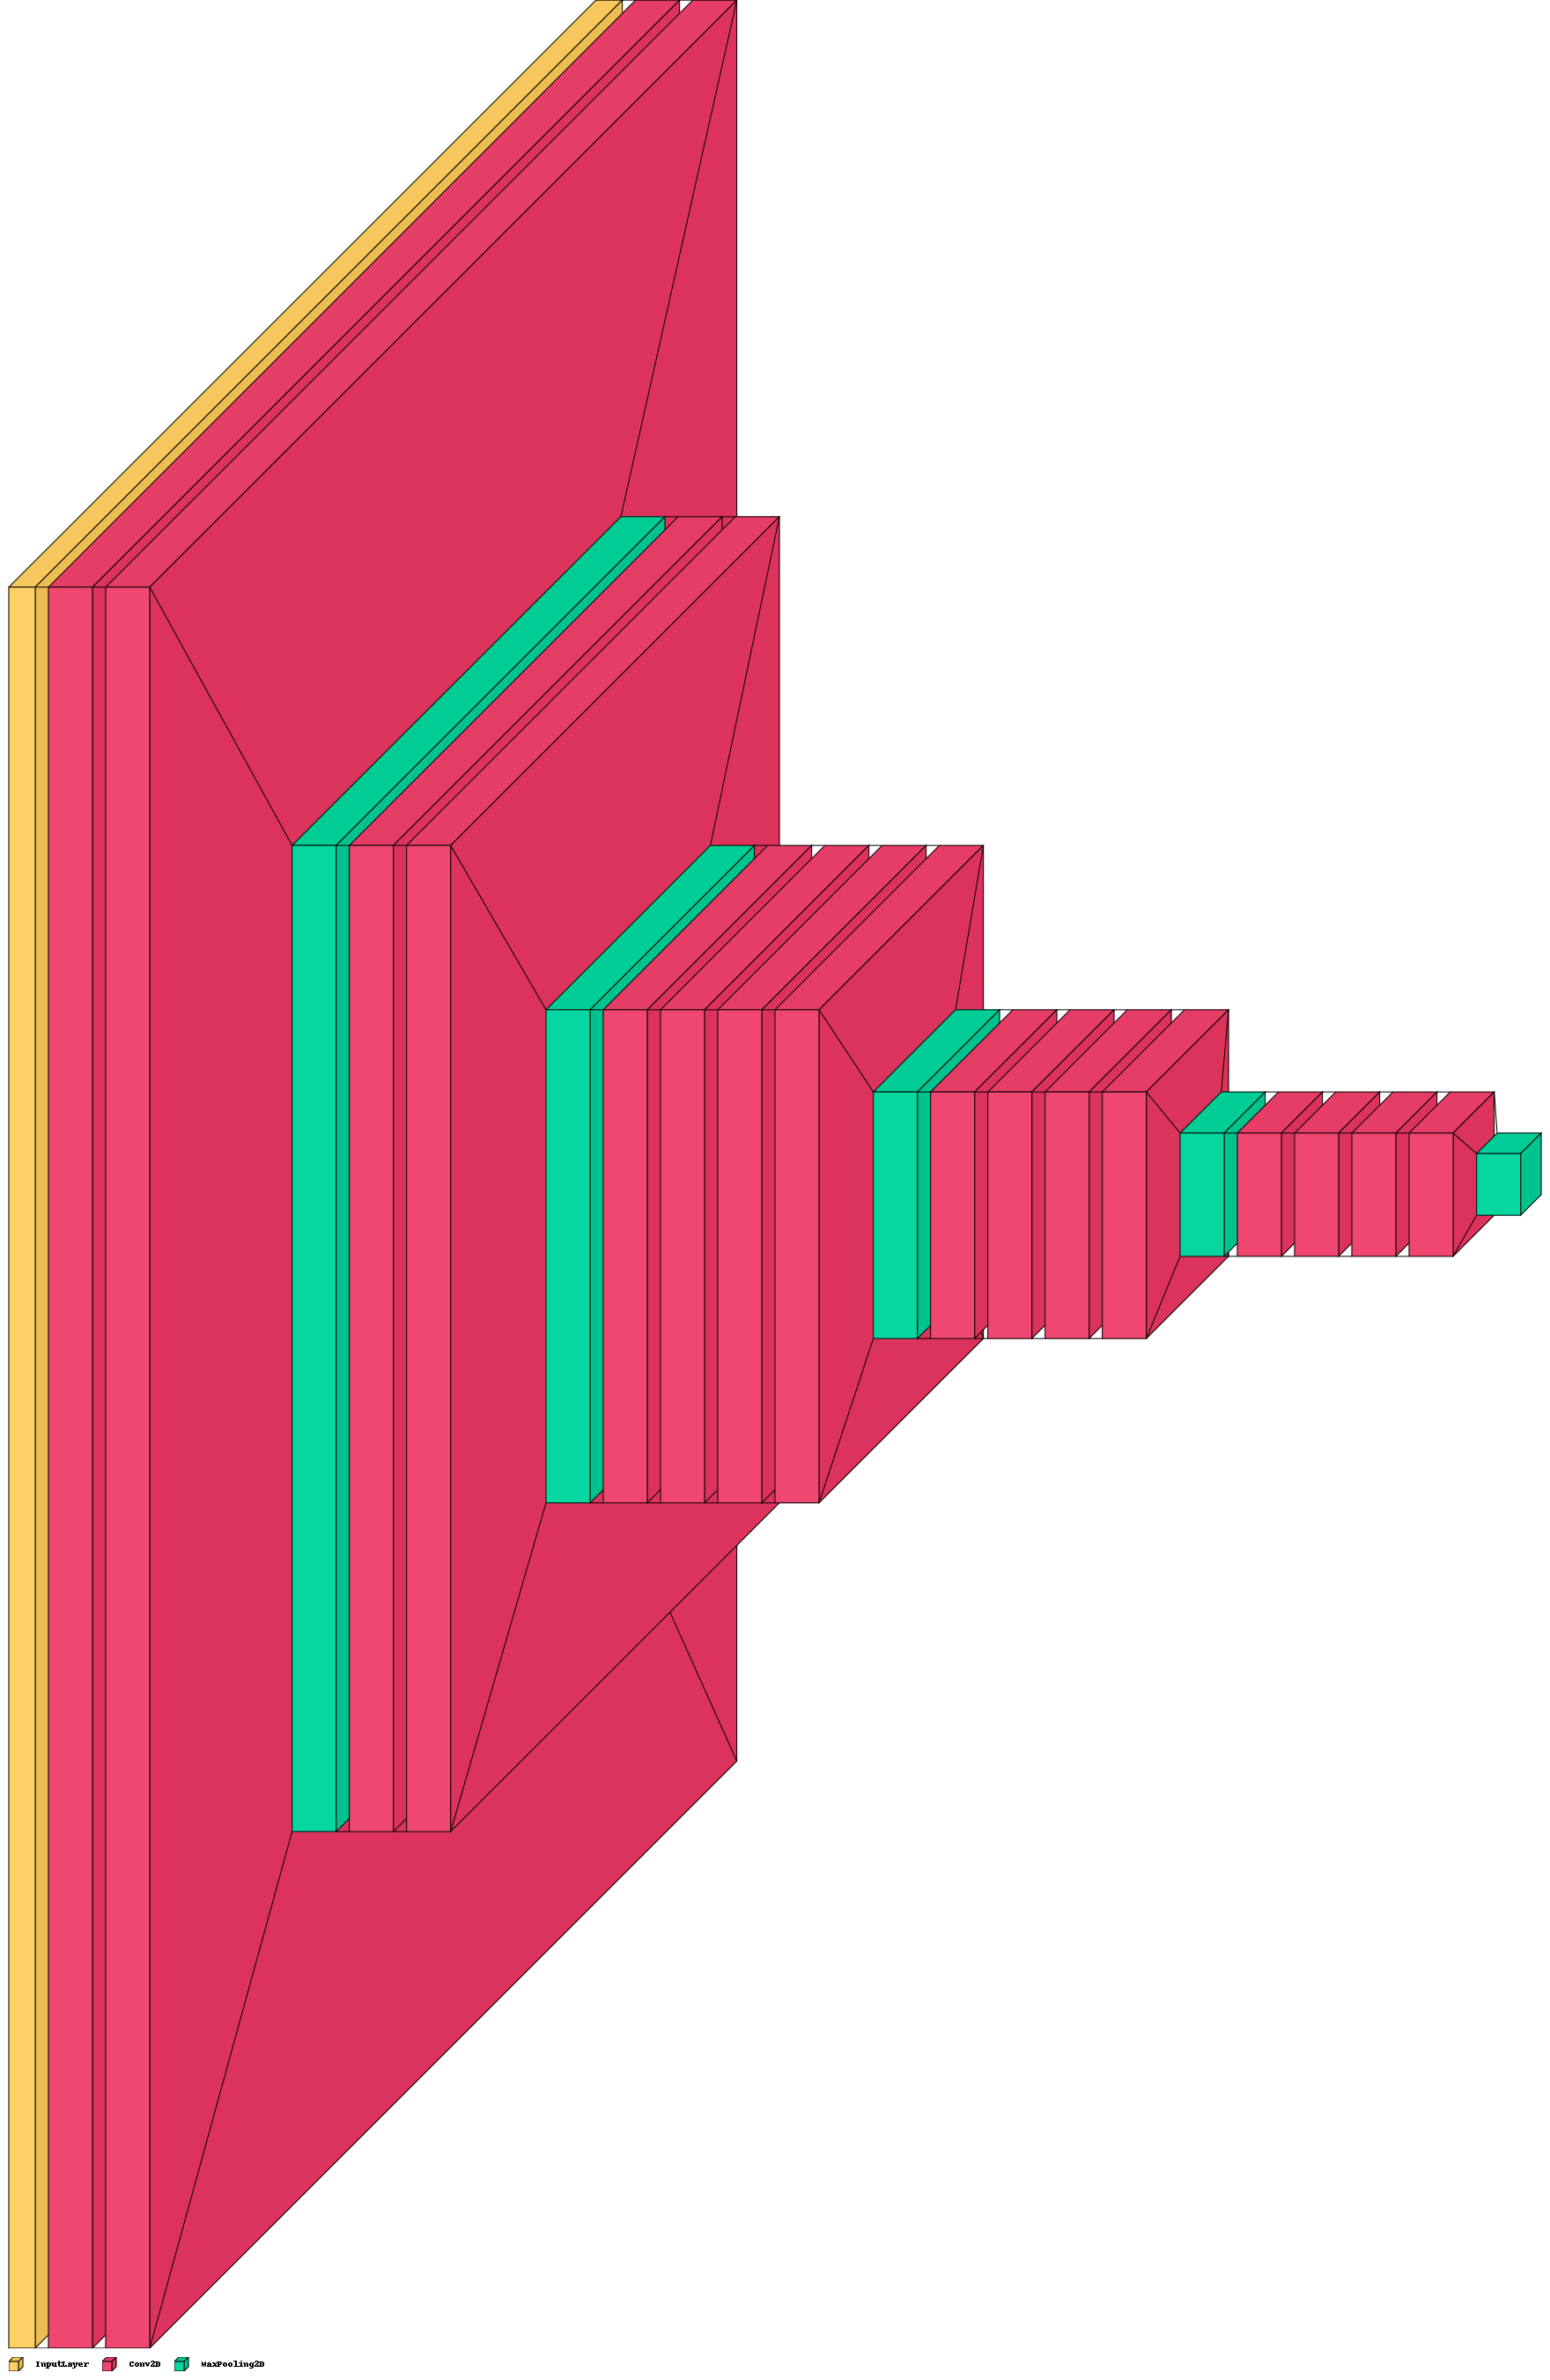

<Figure size 144x144 with 0 Axes>

In [15]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(VGG_model, legend=True,spacing=15,scale_xy = 10 , scale_z = 10, max_z = 50) 

In [16]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

# knn

In [17]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [18]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = knn_model.predict(X_test_features)

In [19]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.4
MSE: 0.6349442379182156
RMSE: 0.7968338835153884
R2 Square 0.49661099994127433
Accuracy 0.7107806691449814
__________________________________


In [20]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, prediction) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.4,0.634944,0.796834,0.496611,0.710781


In [21]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.59      0.64      0.61       353
           1       0.70      0.56      0.62       343
           2       0.64      0.76      0.70       321
           3       0.95      0.89      0.92       328

    accuracy                           0.71      1345
   macro avg       0.72      0.71      0.71      1345
weighted avg       0.72      0.71      0.71      1345



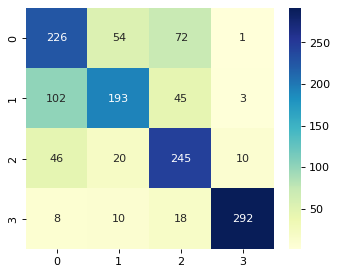

In [22]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [24]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = cart_model.predict(X_test_features)

In [25]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5405204460966543
MSE: 0.9107806691449815
RMSE: 0.9543482955111208
R2 Square 0.27792561466986077
Accuracy 0.6223048327137547
__________________________________


In [26]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.40000,0.634944,0.796834,0.496611,0.710781
1,DecisionTreeClassifier,0.54052,0.910781,0.954348,0.277926,0.622305


In [27]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54       353
           1       0.56      0.56      0.56       343
           2       0.56      0.56      0.56       321
           3       0.82      0.84      0.83       328

    accuracy                           0.62      1345
   macro avg       0.62      0.62      0.62      1345
weighted avg       0.62      0.62      0.62      1345



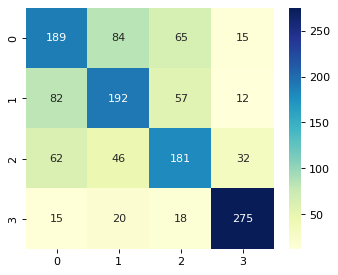

In [28]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [29]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [30]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = lr_model.predict(X_test_features)

In [31]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.25353159851301116
MSE: 0.3754646840148699
RMSE: 0.6127517311398393
R2 Square 0.7023285187006365
Accuracy 0.803717472118959
__________________________________


In [32]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.400000,0.634944,0.796834,0.496611,0.710781
1,DecisionTreeClassifier,0.540520,0.910781,0.954348,0.277926,0.622305
2,LogisticRegression,0.253532,0.375465,0.612752,0.702329,0.803717


In [33]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75       353
           1       0.76      0.70      0.73       343
           2       0.76      0.80      0.78       321
           3       0.97      0.95      0.96       328

    accuracy                           0.80      1345
   macro avg       0.81      0.81      0.81      1345
weighted avg       0.80      0.80      0.80      1345



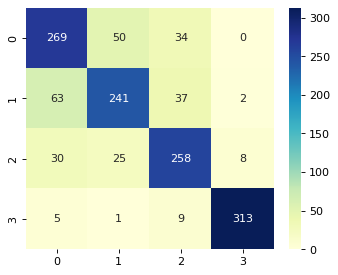

In [34]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [35]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [36]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = LGBM_model.predict(X_test_features)

In [37]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.2572490706319703
MSE: 0.39553903345724906
RMSE: 0.6289189402913933
R2 Square 0.6864134097994824
Accuracy 0.80817843866171
__________________________________


In [38]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.400000,0.634944,0.796834,0.496611,0.710781
1,DecisionTreeClassifier,0.540520,0.910781,0.954348,0.277926,0.622305
2,LogisticRegression,0.253532,0.375465,0.612752,0.702329,0.803717
3,LGBMClassifier,0.257249,0.395539,0.628919,0.686413,0.808178


In [39]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       353
           1       0.78      0.73      0.75       343
           2       0.76      0.81      0.79       321
           3       0.96      0.95      0.96       328

    accuracy                           0.81      1345
   macro avg       0.81      0.81      0.81      1345
weighted avg       0.81      0.81      0.81      1345



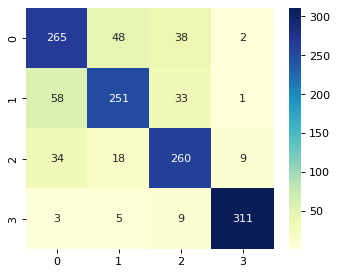

In [40]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [42]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = rf_model.predict(X_test_features)

In [43]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.324907063197026
MSE: 0.5003717472118959
RMSE: 0.7073695973194607
R2 Square 0.6033011744267889
Accuracy 0.7576208178438661
__________________________________


In [44]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.400000,0.634944,0.796834,0.496611,0.710781
1,DecisionTreeClassifier,0.540520,0.910781,0.954348,0.277926,0.622305
2,LogisticRegression,0.253532,0.375465,0.612752,0.702329,0.803717
3,LGBMClassifier,0.257249,0.395539,0.628919,0.686413,0.808178
4,RandomForestClassifier,0.324907,0.500372,0.707370,0.603301,0.757621


In [45]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.67      0.66      0.66       353
           1       0.70      0.68      0.69       343
           2       0.73      0.78      0.75       321
           3       0.94      0.93      0.94       328

    accuracy                           0.76      1345
   macro avg       0.76      0.76      0.76      1345
weighted avg       0.76      0.76      0.76      1345



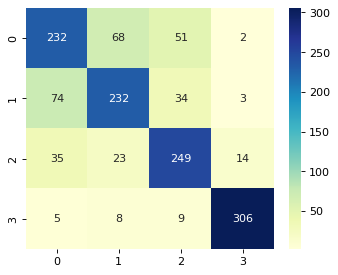

In [46]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [47]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [48]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = GB_model.predict(X_test_features)

In [49]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.5605947955390335
MSE: 0.8936802973977696
RMSE: 0.9453466546181721
R2 Square 0.29148292965973277
Accuracy 0.5933085501858736
__________________________________


In [50]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.400000,0.634944,0.796834,0.496611,0.710781
1,DecisionTreeClassifier,0.540520,0.910781,0.954348,0.277926,0.622305
2,LogisticRegression,0.253532,0.375465,0.612752,0.702329,0.803717
3,LGBMClassifier,0.257249,0.395539,0.628919,0.686413,0.808178
4,RandomForestClassifier,0.324907,0.500372,0.707370,0.603301,0.757621
5,GaussianNB,0.560595,0.893680,0.945347,0.291483,0.593309


In [51]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.53      0.33      0.41       353
           1       0.54      0.55      0.54       343
           2       0.48      0.70      0.57       321
           3       0.89      0.82      0.85       328

    accuracy                           0.59      1345
   macro avg       0.61      0.60      0.59      1345
weighted avg       0.61      0.59      0.59      1345



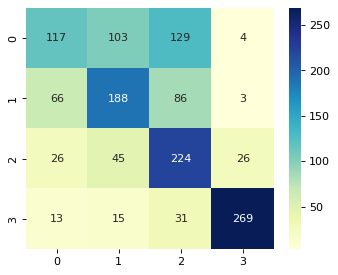

In [52]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [53]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [54]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = SGD_model.predict(X_test_features)

In [55]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.3204460966542751
MSE: 0.48401486988847586
RMSE: 0.6957117721359011
R2 Square 0.6162690409388403
Accuracy 0.7561338289962826
__________________________________


In [56]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.400000,0.634944,0.796834,0.496611,0.710781
1,DecisionTreeClassifier,0.540520,0.910781,0.954348,0.277926,0.622305
2,LogisticRegression,0.253532,0.375465,0.612752,0.702329,0.803717
3,LGBMClassifier,0.257249,0.395539,0.628919,0.686413,0.808178
4,RandomForestClassifier,0.324907,0.500372,0.707370,0.603301,0.757621
5,GaussianNB,0.560595,0.893680,0.945347,0.291483,0.593309
6,SGDClassifier,0.320446,0.484015,0.695712,0.616269,0.756134


In [57]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.59      0.94      0.72       353
           1       0.89      0.42      0.57       343
           2       0.78      0.72      0.75       321
           3       0.96      0.95      0.96       328

    accuracy                           0.76      1345
   macro avg       0.80      0.76      0.75      1345
weighted avg       0.80      0.76      0.75      1345



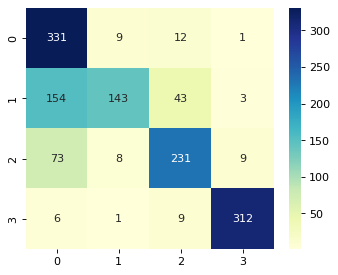

In [58]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SVC

In [59]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [60]:
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
#Now predict using the trained RF model. 
prediction = svm_model.predict(X_test_features)

In [61]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, prediction)

Test set evaluation:
_____________________________________
MAE: 0.25427509293680295
MSE: 0.38810408921933087
RMSE: 0.6229800070783419
R2 Square 0.6923078945776876
Accuracy 0.8096654275092937
__________________________________


In [62]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, prediction)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_vgg19' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.400000,0.634944,0.796834,0.496611,0.710781
1,DecisionTreeClassifier,0.540520,0.910781,0.954348,0.277926,0.622305
2,LogisticRegression,0.253532,0.375465,0.612752,0.702329,0.803717
3,LGBMClassifier,0.257249,0.395539,0.628919,0.686413,0.808178
4,RandomForestClassifier,0.324907,0.500372,0.707370,0.603301,0.757621
5,GaussianNB,0.560595,0.893680,0.945347,0.291483,0.593309
6,SGDClassifier,0.320446,0.484015,0.695712,0.616269,0.756134
7,SVC,0.254275,0.388104,0.622980,0.692308,0.809665


In [63]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76       353
           1       0.78      0.71      0.75       343
           2       0.75      0.81      0.78       321
           3       0.99      0.94      0.96       328

    accuracy                           0.81      1345
   macro avg       0.81      0.81      0.81      1345
weighted avg       0.81      0.81      0.81      1345



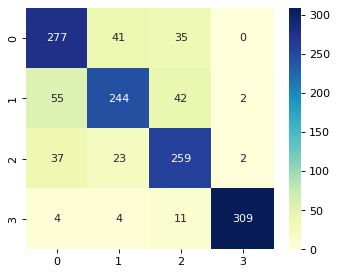

In [64]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [65]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]


In [66]:
sonuc = []
from sklearn.metrics import accuracy_score

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_vgg19"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_features)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_vgg19"])
    sonuclar = sonuclar.append(sonuc)
    

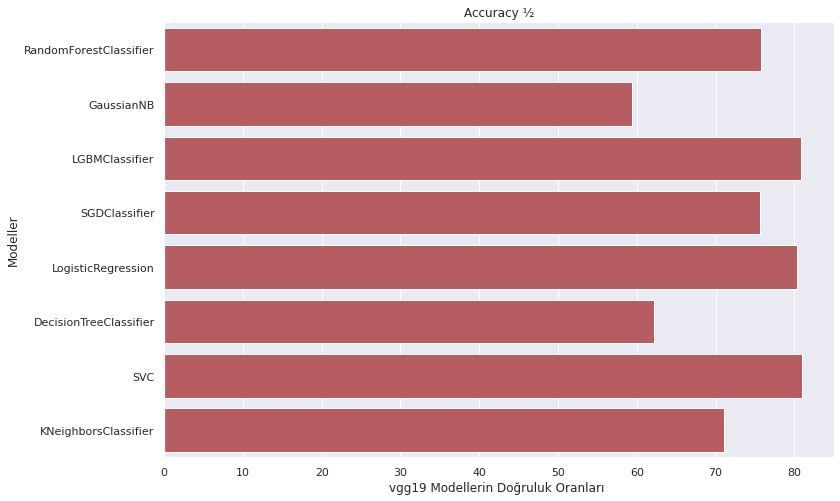

In [67]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x= 'Accuracy_vgg19', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('vgg19 Modellerin Doğruluk Oranları ')
plt.title('Accuracy ½'); 

In [68]:
best_acc=sonuclar.sort_values(by=['Accuracy_vgg19'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model

,Modeller,Accuracy_vgg19
0,SVC,80.966543


In [69]:
results_df


,Model,MAE,MSE,RMSE,R2 Square,Accuracy_vgg19
0,KNeighborsClassifier,0.400000,0.634944,0.796834,0.496611,0.710781
1,DecisionTreeClassifier,0.540520,0.910781,0.954348,0.277926,0.622305
2,LogisticRegression,0.253532,0.375465,0.612752,0.702329,0.803717
3,LGBMClassifier,0.257249,0.395539,0.628919,0.686413,0.808178
4,RandomForestClassifier,0.324907,0.500372,0.707370,0.603301,0.757621
5,GaussianNB,0.560595,0.893680,0.945347,0.291483,0.593309
6,SGDClassifier,0.320446,0.484015,0.695712,0.616269,0.756134
7,SVC,0.254275,0.388104,0.622980,0.692308,0.809665


In [71]:
from google.colab import files

results_df.to_csv('output_vgg19_224.csv', encoding = 'utf-8-sig') 
files.download('output_vgg19_224.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>